# GPR and Lidar

## Author: Randall Bonnell

## Outline:
1. GPR Methods for the Retrieval of Snow Depth and SWE
2. Lidar Methods for Snow Depth Retrieval and SWE Estimation
3. Leveraging Coincident GPR and Lidar Data Sets to Derive Snow Density
4. SnowEx23 GPR/Lidar Derived Permittivities/Densities in the Boreal Forest, Alaska
5. Discussion: Improving Density Estimation
6. GPR SnowEx Analysis-Ready Datasets
7. References

![Title Card](./images/gpr_lidar/HackweekGraphicalAbstract_GPR_Lidar_v2.png)

## 1. GPR Methods for the Retrieval of Snow Depth and SWE

### Previous GPR tutorial developed by Tate Meehan (CRREL) that may be of interest: https://snowex-2021.hackweek.io/tutorials/gpr/gpr.html

### SnowEx Review
- Ground-based, airborne, and satellite radars were operated as part of the NASA SnowEx campaigns.
- Ground-based radars included ground-penetrating radar (GPR), frequency-modulated continuous-wave radar (FMCW), and tower mounted radars.
- What airborne and satellite radars were tasked?

### A Brief Blurb on Radar Physics
- Radar is fully transmissible in dry snow, but there is frequency-dependent interaction between the radar signal and the snowpack.
- At L-band frequencies (1–2 GHz, ~25 cm wavelength) there limited to no interaction with the snowpack.

### What is GPR?
- We use L-band GPR, which was operated during all SnowEx campaigns!
- GPR transmits a radar signal into the snowpack, which then reflects off objects/interfaces with contrasting dielectric permittivity. The GPR records the amplitude and two-way travel time (twt) of the reflections.
- Dielectric permittivity refers to the dielectric properties of the snowpack that define how EM energy transmits through the medium.
- Usually, we are interested in the snow-ground interface and we measure the snowpack thickness in twt (nanoseconds).
- However, in complex vegetation, radargrams are difficult to interpret! Causes increased uncertainty.
- See radargram examples below for the boreal forest GPR surveys (credit Kajsa Holland-Goon).

![Radargram Examples](./images/gpr_lidar/radargrams.png)

### Snow Depth, SWE, and Density Calculations
- To calculate snow depth $(d_s)$ from twt, we need to estimate the relative permittivity $(\epsilon_s)$ and radar velocity $(v_s)$ of the snowpack:
    - $v_s = \frac{c}{\sqrt{\epsilon_s}}$; --> Where c is the velocity of EM energy in a vacuum.
    - $\epsilon_s = (1+\frac{0.845\rho_s}{1000})^2$; --> Kovacs et al. (1995), but more than 19 equations exist for dry snow conditions.
    - $d_s = \frac{twt}{2}*v_s;$
    - $SWE = d_s\rho_s;$--> Where SWE is snow water equivalent.
- But...If we know the snow depth, we can constrain the radar velocity and estimate relative permittivity and density!
    - $\epsilon_s=(\frac{c*twt}{2d_s})^2$
    - $\rho_s=(\sqrt{\epsilon_s}-1)\frac{1000}{0.845}$
 - How can we find the snow depth?

### A Shameless Plug...
- Most analysis-ready GPR products have twt, snow depth, and snow water equivalent. Some have been updated with derived snow densities. See _6. SnowEx GPR Analysis-Ready Datasets_ below.

## 2. Lidar Methods for Snow Depth Retrieval and SWE Estimation
### Previous lidar tutorial developed by Naheem Adebisi (ESRI) that may be of interest: https://snowex-2022.hackweek.io/tutorials/lidar/index.html

### A (Very) General Review of Lidar
- Lidar emits photons and measures the twt of the returned photons
- These twt are converted to elevation surfaces (e.g., DEM, DTM, DSM).
- Lidar can be collected from a variety of platforms:
    - Terrestrial
    - UAV
    - Airborne
    - Satellite
- Two acquisitions are required for snow, a snow-on acquisition and a snow-off acquisition. Snow depth can be calculated in two general ways:
    - Raster-based approaches (see figure below, credit Airborne Snow Observatories Inc.)
    - Point cloud approaches

### How is SWE calculated from lidar snow depths?
- At larger scales, SWE is calculated via modeled densities (e.g., M3 Works and ASO).
- At smaller field sites, it may be appropriate to use representative in situ measurements.

![ASO Lidar Figure](./images/gpr_lidar/aso_figure.png)

## 3. Leveraging Coincident GPR and Lidar Data Sets to Derive Snow Density
- Density, liquid water content, and relative permittivity are understudied relative to snow depth and/or SWE.
- Combined coincident snow depths and twt can yield spatially distributed measurements of relative permittivity.
    - In wet snow, relative permittivity can be converted to liquid water content (e.g., Webb et al., 2018, 2020, 2022; Bonnell et al., 2021).
    - In dry snow, density can be estimated from the relative permittivity (Yildiz et al., 2021; McGrath et al., 2022; Bonnell et al., 2023; Meehan et al., 2024).
- This technique has provided an unprecedented glimpse into the spatial properties of these parameters!
- Critically, studies have noted a large random error in derived products that should be considered (see figure below, credit: Meehan et al., 2024).


![Meehan2024](./images/gpr_lidar/MeehanFigure.png)

## 4. SnowEx23 GPR/Lidar Derived Permittivities/Densities in the Boreal Forest, Alaska

### Here, we will use this approach to derive densities at Farmer's Loop Creamer's Field during the SnowEx23 Alaska Campaign
- Lidar data was collected on 11 March 2023
- GPR data was collected on 7, 11, 13, and 16 March 2023


In [1]:
#1.1 Load relevant packages
import os
import numpy as np 
from datetime import date
from scipy.spatial import cKDTree

#packages for figures
import matplotlib.pyplot as plt
from rasterio.plot import show

#geospatial packages
import geopandas as gpd #for vector data
import xarray as xr
import rioxarray #for raster data
import pandas as pd
from shapely.geometry import box, Point
import rasterio as rio

#Import SnowEx database
from snowexsql.api import PointMeasurements, LayerMeasurements, RasterMeasurements


### Part 1: Load the GPR data from the SnowEx data base
-Huge thank you to Micah Johnson and Micah Sandusky for their support!
- Note that if we used the full GPR/Lidar dataset, we would need to allocate way more memory. This example focuses on a single date of collection in very dense forest.
- Examine the headers from the GPR csv --> what are the variables that we are interested in?

In [2]:
# 1.2 Load GPR data

#Note, memory space is fairly limited, will need to pull only one date

#Set a number of dates to pull GPR for
#dt1 = date(2023, 3, 7)
dt2 = date(2023, 3, 11)
#dt3 = date(2023, 3, 13)
#dt4 = date(2023, 3, 16)

#site1 = LayerMeasurements.from_filter(date=dt1, site_name='Fairbanks', site_id='FLCF', limit=1)
site2 = LayerMeasurements.from_filter(date=dt2, site_name='Fairbanks', site_id='FLCF', limit=1)
#site3 = LayerMeasurements.from_filter(date=dt3, site_name='Fairbanks', site_id='FLCF', limit=1)
#site4 = LayerMeasurements.from_filter(date=dt4, site_name='Fairbanks', site_id='FLCF', limit=1)

#Use pandas ot read in csv data
#gpr_df_dt1 = PointMeasurements.from_area(pt=site1.geometry[0], crs=26906, buffer=10000,
#    type='two_way_travel',
#    observers='Randall Bonnell',
#    date=dt1, site_name='farmers-creamers',
#    limit=29432)#The number of expected measurements
gpr_df_dt2 = PointMeasurements.from_area(pt=site2.geometry[0], crs=26906, buffer=10000,
    type='two_way_travel',
    observers='Randall Bonnell',
    date=dt2, site_name='farmers-creamers',
    limit=20213)#The number of expected measurements
#gpr_df_dt3 = PointMeasurements.from_area(pt=site3.geometry[0], crs=26906, buffer=10000,
#    type='two_way_travel',
#    observers='Randall Bonnell',
#    date=dt3, site_name='farmers-creamers',
#    limit=19024)
#gpr_df_dt4 = PointMeasurements.from_area(pt=site4.geometry[0], crs=26906, buffer=10000,
#    type='two_way_travel',
#    observers='Randall Bonnell',
#    date=dt4, site_name='farmers-creamers',
#    limit=15785)


#Compile into one dataframe
#flcf_gpr_df = pd.concat([gpr_df_dt1,gpr_df_dt2,gpr_df_dt3,gpr_df_dt4],axis=0, join='outer', ignore_index=True, keys=None, levels=None,names=None,verify_integrity=False,sort=False,copy=None)
flcf_gpr_df = gpr_df_dt2
#Print out the csv headers and initial entries --> What's important here and what do we need?
print(flcf_gpr_df.head())

  version_number equipment     value   latitude   longitude      northing  \
0           None      None  2.750000  64.873587 -147.695533  7.194547e+06   
1           None      None  2.993355  64.873572 -147.695581  7.194546e+06   
2           None      None  2.450000  64.873588 -147.695531  7.194547e+06   
3           None      None  2.842746  64.873572 -147.695580  7.194546e+06   
4           None      None  2.842746  64.873573 -147.695578  7.194546e+06   

         easting elevation  utm_zone                            geom  ...  \
0  467046.578651      None         6  POINT (467046.579 7194547.363)  ...   
1  467044.267331      None         6  POINT (467044.267 7194545.619)  ...   
2  467046.657725      None         6  POINT (467046.658 7194547.424)  ...   
3  467044.351761      None         6  POINT (467044.352 7194545.672)  ...   
4  467044.436181      None         6  POINT (467044.436 7194545.726)  ...   

         date                     time_created time_updated       id   doi

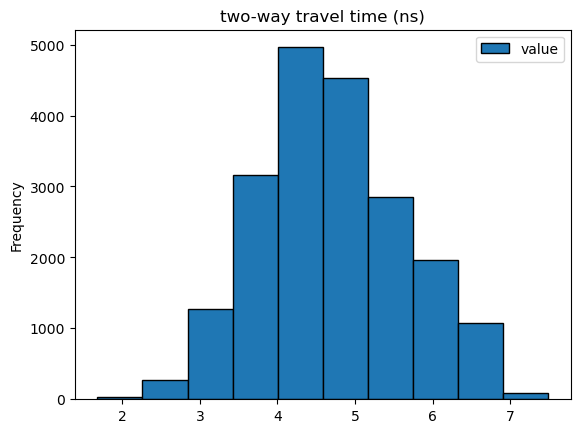

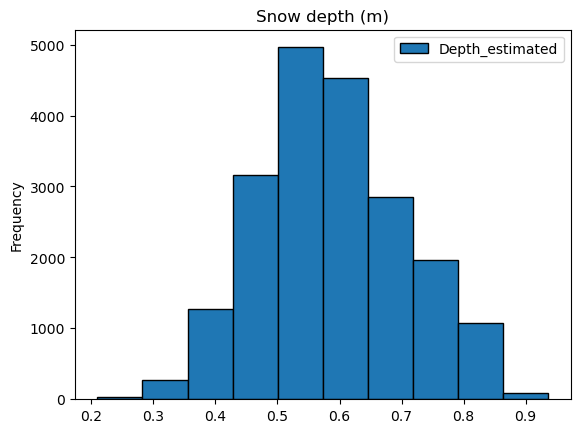

In [3]:
# Let's look at the distribution of gpr two-way travel times and estimated snow depths
#Estimate snow depths from twt by assuming a velocity of 0.25 m/ns --> Is this an appropriate velocity estimate?
flcf_gpr_df['Depth_estimated'] = (flcf_gpr_df['value']/2)*0.25

ax1 = flcf_gpr_df.plot.hist(column=["value"], edgecolor='black', title='two-way travel time (ns)')
ax2 = flcf_gpr_df.plot.hist(column=["Depth_estimated"], edgecolor='black', title='Snow depth (m)')

In [4]:
#Extract x/y limits from GPR data --> these will be used when loading the lidar snow depths
bounds = flcf_gpr_df.total_bounds

# Create a bounding box
gpr_limits = box(*bounds)

### Let's load in the lidar canopy heights and snow depths.
- We'll look at the canopy heights to get an idea of what kind of forest the data were collected in.
- Then, we'll look at the lidar snow depths to visualize the snow distribution.

### Discussion questions:
- What type of survey design was implemented for the GPR?
- Do the lidar snow depth patterns seem to exhibit any kind of dependence upon the forest cover?

In [6]:
""" # 1.3 Load Lidar vegetation/canopy heights --> This may take a few minutes
#Read in the canopy heights raster from Farmer's Loop/Creamer's Field Alaska
flcf_ch = RasterMeasurements.from_area(shp = gpr_limits, crs=26906,
    buffer=None, type='canopy_height',
    site_name='farmers-creamers',
    observers='chris larsen')
print(flcf_ch)

#Plot the datasets
fig, ax = plt.subplots()
show(flcf_ch, ax=ax, cmap='Greens', clim=(0,5), title = 'Canopy Height (m)')
#Plot the GPR points on top
flcf_gpr_df.plot(ax=ax, color='blue', markersize = 10) """

" # 1.3 Load Lidar vegetation/canopy heights --> This may take a few minutes\n#Read in the canopy heights raster from Farmer's Loop/Creamer's Field Alaska\nflcf_ch = RasterMeasurements.from_area(shp = gpr_limits, crs=26906,\n    buffer=None, type='canopy_height',\n    site_name='farmers-creamers',\n    observers='chris larsen')\nprint(flcf_ch)\n\n#Plot the datasets\nfig, ax = plt.subplots()\nshow(flcf_ch, ax=ax, cmap='Greens', clim=(0,5), title = 'Canopy Height (m)')\n#Plot the GPR points on top\nflcf_gpr_df.plot(ax=ax, color='blue', markersize = 10) "

In [ ]:
# 1.4 Load Lidar Snow depths --> This will take a few minutes

#Read in the canopy heights raster from Farmer's Loop/Creamer's Field Alaska
flcf_ds = RasterMeasurements.from_area(shp = gpr_limits, crs=26906,
    buffer=None, type='depth',
    site_name='farmers-creamers',
    observers='chris larsen')

#Plot the datasets
fig, ax = plt.subplots()
show(flcf_ds, ax=ax, cmap='Blues', clim=(0,1.5), title='Snow Depth (m)')
#Plot the GPR points on top
flcf_gpr_df.plot(ax=ax, color='red', markersize = 10)

### Part 2: Match the GPR data to the lidar grid and derive relative permittivity and density
- There are two conceptual paths forward:
    - Rasterize the GPR data or
    - Vectorize the lidar data
- For simplicity, the following code:
    - vectorizes the lidar data
    - performs a nearest neighbor search between the lidar and GPR coordinate vectors
    - Calculates the median GPR twt from the nearest neighbors
    - Derives relative permittivity and density from the lidar snow depths and median twt

### We need to know the resolutions of the lidar and GPR datasets

- The GPR dataset consists of points that are spaced ~0.10 m apart.
- What about the lidar? Run the code block below to answer this question.
- How many GPR points would you expect to have per lidar pixel? Assume linear transects through each pixel.

In [7]:
""" #2.1 Let's learn a bit about the resolution of the lidar rasters

height, width = flcf_ds.read(1).shape #Find the height and width of the array

#Use meshgrid to create two arrays matching the height/width of the input raster
#The GPR dataset consists of vectors --> we will eventually need to vectorize these lidar arrays
cols, rows = np.meshgrid(np.arange(width), np.arange(height)) 


#Extract the easting/northing from the raster 
x_lidar, y_lidar = rio.transform.xy(flcf_ds.transform, rows, cols) 

#What's the resolution of the lidar dataset?
print("The x resolution of the snow depth raster is:",x_lidar[0][1]-x_lidar[0][0])
print("The y resolution of the snow depth raster is:",y_lidar[0][0]-y_lidar[1][0])
 """

' #2.1 Let\'s learn a bit about the resolution of the lidar rasters\n\nheight, width = flcf_ds.read(1).shape #Find the height and width of the array\n\n#Use meshgrid to create two arrays matching the height/width of the input raster\n#The GPR dataset consists of vectors --> we will eventually need to vectorize these lidar arrays\ncols, rows = np.meshgrid(np.arange(width), np.arange(height)) \n\n\n#Extract the easting/northing from the raster \nx_lidar, y_lidar = rio.transform.xy(flcf_ds.transform, rows, cols) \n\n#What\'s the resolution of the lidar dataset?\nprint("The x resolution of the snow depth raster is:",x_lidar[0][1]-x_lidar[0][0])\nprint("The y resolution of the snow depth raster is:",y_lidar[0][0]-y_lidar[1][0])\n '

In [8]:
""" # 2.2 Matching GPR to the lidar grid

#Two conceptual paths forward: rasterize the GPR data, or convert lidar data to points

#Let's vectorize the raster data
x_lidar_vec = np.array(x_lidar).flatten()
y_lidar_vec = np.array(y_lidar).flatten()
flcf_ds_vec = flcf_ds.read().flatten()

#Pull vectors from geo dataframe
gpr_arr = np.stack([flcf_gpr_df.geometry.x, flcf_gpr_df.geometry.y,flcf_gpr_df['value']], axis=1)
gpr_x=gpr_arr[:,0]
gpr_y=gpr_arr[:,1]
gpr_twt=gpr_arr[:,2].reshape(len(gpr_arr[:,2]),1)
 """

" # 2.2 Matching GPR to the lidar grid\n\n#Two conceptual paths forward: rasterize the GPR data, or convert lidar data to points\n\n#Let's vectorize the raster data\nx_lidar_vec = np.array(x_lidar).flatten()\ny_lidar_vec = np.array(y_lidar).flatten()\nflcf_ds_vec = flcf_ds.read().flatten()\n\n#Pull vectors from geo dataframe\ngpr_arr = np.stack([flcf_gpr_df.geometry.x, flcf_gpr_df.geometry.y,flcf_gpr_df['value']], axis=1)\ngpr_x=gpr_arr[:,0]\ngpr_y=gpr_arr[:,1]\ngpr_twt=gpr_arr[:,2].reshape(len(gpr_arr[:,2]),1)\n "

In [9]:
""" #2.3 Create sets of coordinates for the nearest neighbors search
coordinates_set1 = np.column_stack((x_lidar_vec,y_lidar_vec))
coordinates_set2 = np.column_stack((gpr_x,gpr_y))

# Build KDTree from the second set of coordinates
tree = cKDTree(coordinates_set2)

# Define the radius (in meters)
radius = 0.25

# Function to find the median of travel times within a radius --> Credit where credit is due, this function was generated in part by chatgpt
def find_median_travel_time_within_radius(point, tree, coordinates_set1, gpr_twt, radius):
    indices = tree.query_ball_point(point, radius)
    if indices:
        # Retrieve travel times for the nearest neighbors
        neighbor_twt = gpr_twt[indices]
        median_twt = np.median(neighbor_twt)
        return median_twt
    else:
        return np.nan  # Return NaN if no neighbors are within the radius
# Find medians for each lidar point
medians = np.array([find_median_travel_time_within_radius(point, tree, coordinates_set2, gpr_twt, radius) for point in coordinates_set1])
 """

' #2.3 Create sets of coordinates for the nearest neighbors search\ncoordinates_set1 = np.column_stack((x_lidar_vec,y_lidar_vec))\ncoordinates_set2 = np.column_stack((gpr_x,gpr_y))\n\n# Build KDTree from the second set of coordinates\ntree = cKDTree(coordinates_set2)\n\n# Define the radius (in meters)\nradius = 0.25\n\n# Function to find the median of travel times within a radius --> Credit where credit is due, this function was generated in part by chatgpt\ndef find_median_travel_time_within_radius(point, tree, coordinates_set1, gpr_twt, radius):\n    indices = tree.query_ball_point(point, radius)\n    if indices:\n        # Retrieve travel times for the nearest neighbors\n        neighbor_twt = gpr_twt[indices]\n        median_twt = np.median(neighbor_twt)\n        return median_twt\n    else:\n        return np.nan  # Return NaN if no neighbors are within the radius\n# Find medians for each lidar point\nmedians = np.array([find_median_travel_time_within_radius(point, tree, coordinat

### The GPR data is not as spatially continuous as the lidar data, so most of the median twt dataset consists of nan's
- Let's remove the nan's to free up memory and reduce processing time.

In [10]:
""" #At this point, all lidar points should have an associated gpr twt --> most are likely nan's though. But let's check!
print("The gpr array has size:",medians.shape)
print("The lidar array has size:",flcf_ds_vec.shape)
 """

' #At this point, all lidar points should have an associated gpr twt --> most are likely nan\'s though. But let\'s check!\nprint("The gpr array has size:",medians.shape)\nprint("The lidar array has size:",flcf_ds_vec.shape)\n '

In [11]:
""" #2.4 Before we get to the math part, let's clear out the nan's from all important vectors:
#Create mask for gpr medians that are nan's
mask = np.isnan(medians)

#Remove entries from the lidar snow depth, x, and y vectors that align with the nan twt values
flcf_ds_vec_clean = flcf_ds_vec[~mask]
coordinates_set1_clean=coordinates_set1[~mask]

#Lastly, remove entries from the twt medians
medians_clean = medians[~mask]

#Let's check the new size of the twt array
print(medians_clean.shape)

 """

" #2.4 Before we get to the math part, let's clear out the nan's from all important vectors:\n#Create mask for gpr medians that are nan's\nmask = np.isnan(medians)\n\n#Remove entries from the lidar snow depth, x, and y vectors that align with the nan twt values\nflcf_ds_vec_clean = flcf_ds_vec[~mask]\ncoordinates_set1_clean=coordinates_set1[~mask]\n\n#Lastly, remove entries from the twt medians\nmedians_clean = medians[~mask]\n\n#Let's check the new size of the twt array\nprint(medians_clean.shape)\n\n "

### Discussion questions:
- Roughly, how many points were removed?
- When we are done, we will have derived 3788 snow density estimates. In the same area, about four snow pits were dug, resulting in four bulk density measurements. How useful do you think our data will be?
- Is more always better?

### Let's now transition to the relative permittivity and density calculations

In [12]:
""" #2.5 We finally get to the math part!!
#Let's calculate relative permittivity first...
c=0.2998#The speed of light in a vacuum
e_s = ((c * medians_clean) / (2 * flcf_ds_vec_clean)) ** 2

#And then calculate density
rho_s = ((np.sqrt(e_s) - 1) / 0.845) * 1000 """

" #2.5 We finally get to the math part!!\n#Let's calculate relative permittivity first...\nc=0.2998#The speed of light in a vacuum\ne_s = ((c * medians_clean) / (2 * flcf_ds_vec_clean)) ** 2\n\n#And then calculate density\nrho_s = ((np.sqrt(e_s) - 1) / 0.845) * 1000 "

### Part 3: Examining the derived densities

In [13]:
""" # 3.1 Finally, let's take a peek at what the derived densities look like...
plt.figure()
plt.scatter(coordinates_set1_clean[:,0], coordinates_set1_clean[:,1], s=10, c=rho_s, cmap='viridis', clim=(0, 500), edgecolor=None)

# Add colorbar to show the scale of color values
plt.colorbar()
plt.title('Snow Density (kg m-3)')

# Show the plot
plt.show() """

" # 3.1 Finally, let's take a peek at what the derived densities look like...\nplt.figure()\nplt.scatter(coordinates_set1_clean[:,0], coordinates_set1_clean[:,1], s=10, c=rho_s, cmap='viridis', clim=(0, 500), edgecolor=None)\n\n# Add colorbar to show the scale of color values\nplt.colorbar()\nplt.title('Snow Density (kg m-3)')\n\n# Show the plot\nplt.show() "

In [14]:
""" # 3.2 What does the histogram distribution look like??
# Define bin edges
bin_edges = np.arange(np.min(rho_s), np.max(rho_s), 25)  # Create bin edges from min(x) to max(x) with step size 25

# Create the histogram
plt.figure()  # Create a new figure
plt.hist(rho_s, bins=bin_edges, edgecolor=None)  # Plot histogram with specified bin edges

plt.title('Snow Density Histogram')

# Show the plot
plt.show() """

" # 3.2 What does the histogram distribution look like??\n# Define bin edges\nbin_edges = np.arange(np.min(rho_s), np.max(rho_s), 25)  # Create bin edges from min(x) to max(x) with step size 25\n\n# Create the histogram\nplt.figure()  # Create a new figure\nplt.hist(rho_s, bins=bin_edges, edgecolor=None)  # Plot histogram with specified bin edges\n\nplt.title('Snow Density Histogram')\n\n# Show the plot\nplt.show() "

In [15]:
""" #Let's zoom in a little...
# Define bin edges
bin_edges = np.arange(0, 500, 25)  # Create bin edges from min(x) to max(x) with step size 25

# Create the histogram
plt.figure()  # Create a new figure
plt.hist(rho_s, bins=bin_edges, edgecolor='black')  # Plot histogram with specified bin edges

plt.title('Snow Density Histogram')

# Show the plot
plt.show() """

" #Let's zoom in a little...\n# Define bin edges\nbin_edges = np.arange(0, 500, 25)  # Create bin edges from min(x) to max(x) with step size 25\n\n# Create the histogram\nplt.figure()  # Create a new figure\nplt.hist(rho_s, bins=bin_edges, edgecolor='black')  # Plot histogram with specified bin edges\n\nplt.title('Snow Density Histogram')\n\n# Show the plot\nplt.show() "

## 5. Discussion: Improving Density Estimation
- What do you think? Do the derived densities look usable at this stage?

### What contributes to the random error?
There are three groups of factors that control the random error:
1. Measurement accuracy for lidar snow depths and GPR twt. Reduced accuracy for either or both of the techniques will lead to large errors. The boreal forest had a lot of complex vegetation that may have impeded the accuracy of these instruments.
2. Depth of the snowpack. The accuracy of the lidar is not a function of snow depth. Thus, the random errors reduce as the snow depth increases. The boreal forest snow depths were shallow!
3. Geolocation alignment. GPR coordinates were post-processed, but accuracy is still likely on the order of ±3 m.

### Improving the derived densities
Let’s say we want to learn something about snow density in the boreal forest. The derived densities offer a HUGE increase in the number of available density measurements compared to in situ. But, in situ are much more accurate. How can we improve this dataset?

- Increase the footprint of the derived densities by upsampling the lidar (e.g., to 3 m).
    - This will reduce the impact of GPR geolocation accuracy and the lidar/GPR observation uncertainty.
    - Need to be careful! The GPR footprint is large, but it may not scale well past 3 m.
- Remove erroneous values. 
    - How does the lidar survey time compare with the GPR survey time? Was the snow disturbed or did more snow accumulate between surveys?
    - Relative permittivity of snow cannot be less than air $(\epsilon_a = 1.0)$ or greater than liquid water $(\epsilon_w = 88)$.
    - For dry snow, relative permittivity is usually between 1.0 and 2.0. The removal of values outside a certain number of standard deviations and/or the interquartile range may be warranted.
- Run a spatial averaging filter.
    - Our surveys were primarily spirals --> should pair nicely with such a filter!
    - Experiment with the window size of the filter. How would a 5 m x 5 m filter compare to a 25 m x 25 m filter?
    - Should the data be parsed into different forest cover classes before such a filter is run?
    - Be careful of linear transects! Large windows tend to remove any density variability along such transects.
    - Once you reach this point, it is likely that the densities will be analysis ready. You could run a predictive model to fill in the void spaces, use the densities to evaluate models, calculate experimental variograms, etc.


## 6. SnowEx GPR Analysis-Ready Datasets
_Grand Mesa, Colorado (SnowEx 2017, 2020)_
- Webb et al. (2019). https://doi.org/10.5067/G21LGCNLFSC5
- Bonnell et al. (2021). https://doi.org/10.5067/S5EGFLCIAB18
- Meehan (2021). https://doi.org/10.5067/Q2LFK0QSVGS2
- Webb (2021). https://doi.org/10.5067/WE9GI1GVMQF6
- Meehan & Hojatimalekshah (2024). https://doi.org/10.5067/LANQ53RTJ2DR

_Cameron Pass, Colorado (SnowEx 2020, 2021)_
- McGrath et al. (2021). https://doi.org/10.5067/U4Q3X27BMRR4
- Bonnell et al. (2022). https://doi.org/10.5067/SRWGLYCB6ZC4
- Bonnell et al. (2024). https://doi.org/10.5067/W0EJNWUZBYSL

_Jemez Mountains, New Mexico (SnowEx 2020)_
- Webb (2021). https://doi.org/10.5067/H38Q5FTBPZ8K

_Arctic Coastal Plains, Alaska (SnowEx 2023)_
- Webb (2024). https://doi.org/10.5067/H3D9IT1W6JT6

## 7. References
_Lidar Datasets_
- Larsen (2024). https://doi.org/10.5067/BV4D8RRU1H7U

_Relevant GPR LWC Studies_
- Webb et al. (2018). https://doi.org/10.1029/2018WR022680
- Webb et al. (2020). https://doi.org/10.1002/hyp.13686
- Bonnell et al. (2021). https://doi.org/10.3390/rs13214223
- Webb et al. (2022). https://doi.org/10.1002/hyp.14541

_Relevant GPR Density Studies_
- Yildiz et al. (2021). https://doi.org/10.1002/hyp.14190
- McGrath et al. (2022). https://doi.org/10.3389/frsen.2022.886747
- Bonnell et al. (2023). https://doi.org/10.1002/hyp.14996
- Meehan et al. (2024). https://doi.org/10.5194/tc-18-3253-2024